In [1]:
# Pytorch packages
import torch
from torch_geometric.data import Data
import torch.nn as nn
import torch_geometric.nn as pyg_nn
from torch_geometric.utils import to_networkx
from torch_geometric.utils import add_self_loops, degree

# Other packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import meshio

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [11]:
class Geometry():
    def __init__(self, mesh_file):

        self.mesh = meshio.read(mesh_file)
        self.node_pos = torch.tensor(self.mesh.points[:, :2], dtype=torch.float, device=device)
        self.mesh_size = self.mesh.points.shape[0]

        self.create_graph()
        self.get_boundary_points()

    def create_graph(self):
        edges = []
        for cell in self.mesh.cells:
            if cell.type == "triangle":
                for element in cell.data:
                    edges.append([element[0], element[1]])
                    edges.append([element[1], element[0]])

                    edges.append([element[1], element[2]])
                    edges.append([element[2], element[1]])

                    edges.append([element[2], element[0]])
                    edges.append([element[0], element[2]])

        edges = torch.tensor(edges, dtype=torch.long, device=device).t().contiguous()
        
        source_nodes = edges[0]
        target_nodes = edges[1]

        source_pos = self.node_pos[source_nodes]
        target_pos = self.node_pos[target_nodes]
        edge_length = torch.norm(source_pos - target_pos, dim=1, keepdim=True)
        
        self.graph = Data(x=self.node_pos, edge_index=edges, edge_attr=edge_length).to(device)
        self.graph.x.requires_grad_(True)

        print(self.graph)
        
    def get_boundary_points(self):
        self.bc_pts = self.mesh.point_sets
        self.keys = self.bc_pts.keys()


In [71]:
# Define the Physics-Informed Graph Convolutional Network (GCN)
class PhysicsInformedGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3):
        super(PhysicsInformedGCN, self).__init__()
        self.convs = nn.ModuleList()
        # First layer: input to hidden
        self.convs.append(pyg_nn.GCNConv(in_channels, hidden_channels))
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(pyg_nn.GCNConv(hidden_channels, hidden_channels))
        # Final layer: hidden to output (e.g., predicted field u)
        self.convs.append(pyg_nn.GCNConv(hidden_channels, out_channels))
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = nn.functional.tanh(x)
        x = self.convs[-1](x, edge_index)
        return x

In [116]:
class PlateSolver():
    def __init__(self, obj):
        self.data = obj.graph
        self.bc_pts = obj.bc_pts

        self.wall_left = self.bc_pts["wall_left"]
        self.free_bot = self.bc_pts["free_bot"]
        self.force_right = self.bc_pts["force_right"]
        self.free_top = self.bc_pts["free_top"]
        self.hole1 = self.bc_pts["hole1"]
        
        self.E = 7e10
        self.sigma_0 = 50e6
        self.U = self.sigma_0 / self.E
        self.nu = 0.33

        self.node_feat_size = 2
        self.edge_feat_size = 1
        self.latent_size = 64
        self.output_size = 5
        self.num_layers = 3

        self.loss_value = []

        self.adam_lr = 0.001

        self.model = PhysicsInformedGCN(2, 64, 5, 5).to(device)
        
        self.optimizer_adam = torch.optim.Adam(self.model.parameters(), lr=self.adam_lr)
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.model.parameters(),
            lr=0.001,
            max_iter=2000,
            max_eval=2000,
            history_size=200,
            tolerance_grad=1e-20,
            tolerance_change=1e-20,
        )
        self.loss_fn = nn.MSELoss()
        self.iter = 0

    def model_value(self, data):
        out = self.model(data)
        u = out[:, 0:1]
        v = out[:, 1:2]
        sxx = out[:, 2:3]
        syy = out[:, 3:4]
        sxy = out[:, 4:5]
        return u, v, sxx, syy, sxy

    def data_loss(self, data, u, v, sxx, syy, sxy):

        ut = self.target[:, 0:1] / self.U
        vt = self.target[:, 1:2] / self.U
        sxxt = self.target[:, 2:3] / self.sigma_0
        syyt = self.target[:, 3:4] / self.sigma_0
        sxyt = self.target[:, 4:5] / self.sigma_0

        out = torch.cat([u, v, sxx, syy, sxy], dim=1)
        target = torch.cat([ut, vt, sxxt, syyt, sxyt], dim=1)

        d = self.loss_fn(out, target)
        return d

    def pde_loss(self, data, u, v, sxx, syy, sxy):

        du = torch.autograd.grad(u, data.x, torch.ones_like(u), create_graph=True)[0]
        du_x = du[:, 0:1]
        du_y = du[:, 1:2]

        dv = torch.autograd.grad(v, data.x, torch.ones_like(v), create_graph=True)[0]
        dv_x = dv[:, 0:1]
        dv_y = dv[:, 1:2]
    
        dsxx_x = torch.autograd.grad(sxx, data.x, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dsyy_y = torch.autograd.grad(syy, data.x, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        
        dsxy = torch.autograd.grad(sxy, data.x, torch.ones_like(sxy), create_graph=True)[0]
        dsxy_x = dsxy[:, 0:1]
        dsxy_y = dsxy[:, 1:2]

        term_xx = 1 / (1 - self.nu**2) * (du_x + self.nu*dv_y)
        term_yy = 1 / (1 - self.nu**2) * (dv_y + self.nu*du_x)
        term_xy = 1 / (2*(1 + self.nu)) * (du_y + dv_x)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dsxx_x + dsxy_y), 2))
        r5 = torch.mean(torch.pow((dsyy_y + dsxy_x), 2))

        residual = r1 + r2 + r3 + r4 + r5
        return residual

    def bc_loss(self, data, u, v, sxx, syy, sxy):

        b = torch.mean(torch.pow(u[self.wall_left], 2))
        b += torch.mean(torch.pow(v[self.wall_left], 2))

        b += torch.mean(torch.pow(syy[self.free_top], 2))
        b += torch.mean(torch.pow(sxy[self.free_top], 2))

        b += torch.mean(torch.pow(sxx[self.force_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.force_right], 2))

        b += torch.mean(torch.pow(syy[self.free_bot], 2))
        b += torch.mean(torch.pow(sxy[self.free_bot], 2))

        x = data.x[:, 0:1]
        y = data.x[:, 1:2]
        nx = - (x[self.hole1] - 1) / 0.1
        ny = - (y[self.hole1] - 0.5) / 0.1
        tx = torch.mul(sxx[self.hole1], nx) + torch.mul(sxy[self.hole1], ny)
        ty = torch.mul(sxy[self.hole1], nx) + torch.mul(syy[self.hole1], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    def loss_func(self, data):
        u, v, sxx, syy, sxy = self.model_value(data)
        # target = self.data_loss(data, u, v, sxx, syy, sxy)
        pde = self.pde_loss(data, u, v, sxx, syy, sxy)
        bc = self.bc_loss(data, u, v, sxx, syy, sxy)

        total_loss = bc + pde
        return total_loss

    def closure(self):
        self.optimizer_lbfgs.zero_grad()
        loss = self.loss_func(self.data)
        loss.backward()

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1
        return loss

    def train(self, epochs=1000):
        self.model.train()

        for epoch in range(epochs):
            self.optimizer_adam.zero_grad()

            loss = self.loss_func(self.data)
            loss.backward()
            self.optimizer_adam.step()

            self.loss_value.append(loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")

        self.optimizer_lbfgs.step(self.closure)
        

In [117]:
mesh_file = "meshes/hole_middle_r10_o1.inp"
obj = Geometry(mesh_file)

Data(x=[5529, 2], edge_index=[2, 64176], edge_attr=[64176, 1])


In [118]:
test = PlateSolver(obj)

In [119]:
test.train(5000)

Epoch 0, Loss: 1.876584e+00
Epoch 100, Loss: 2.369747e-01
Epoch 200, Loss: 1.817140e-01
Epoch 300, Loss: 1.390440e-01
Epoch 400, Loss: 1.280617e-01
Epoch 500, Loss: 1.168221e-01
Epoch 600, Loss: 1.072068e-01
Epoch 700, Loss: 9.904340e-02
Epoch 800, Loss: 9.442976e-02
Epoch 900, Loss: 9.202470e-02
Epoch 1000, Loss: 8.888946e-02
Epoch 1100, Loss: 8.697603e-02
Epoch 1200, Loss: 8.592859e-02
Epoch 1300, Loss: 8.354971e-02
Epoch 1400, Loss: 8.250005e-02
Epoch 1500, Loss: 8.052799e-02
Epoch 1600, Loss: 7.910135e-02
Epoch 1700, Loss: 7.730041e-02
Epoch 1800, Loss: 7.548311e-02
Epoch 1900, Loss: 7.346014e-02
Epoch 2000, Loss: 7.158154e-02
Epoch 2100, Loss: 6.935142e-02
Epoch 2200, Loss: 9.855092e-02
Epoch 2300, Loss: 6.498353e-02
Epoch 2400, Loss: 6.299967e-02
Epoch 2500, Loss: 6.139068e-02
Epoch 2600, Loss: 5.904321e-02
Epoch 2700, Loss: 5.738267e-02
Epoch 2800, Loss: 5.616596e-02
Epoch 2900, Loss: 5.409309e-02
Epoch 3000, Loss: 5.282320e-02
Epoch 3100, Loss: 5.300477e-02
Epoch 3200, Loss: 5.

In [93]:
data = obj.graph
G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

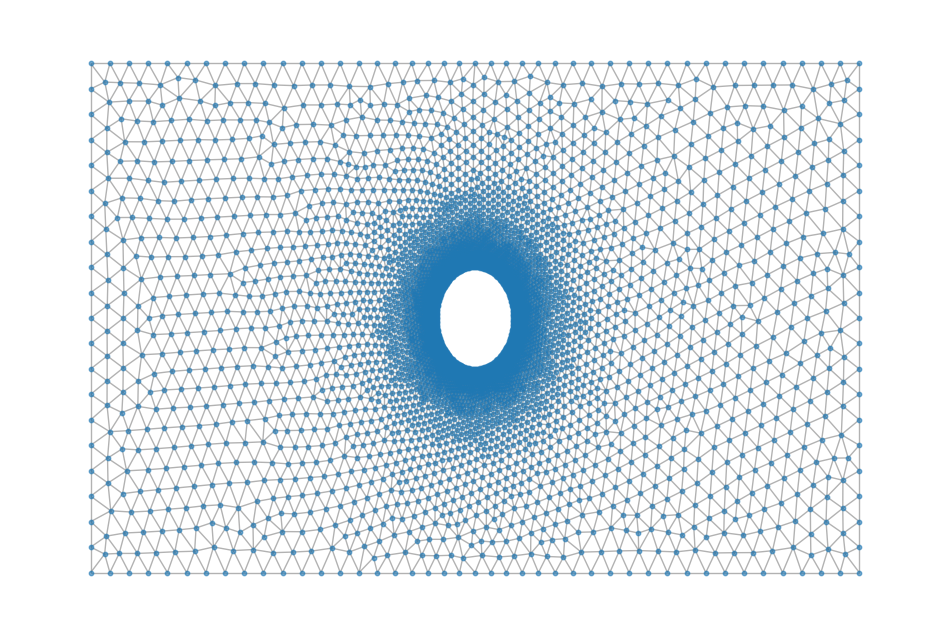

In [94]:
fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6)

plt.show()

In [120]:
data = obj.graph
out = test.model(data)

In [121]:
E = 7e10
sigma_0 = 50e6
U = sigma_0 / E


In [122]:
G = to_networkx(data, to_undirected=True)

pos = {i: (data.x[i, 0].item(), data.x[i, 1].item()) for i in range(data.x.shape[0])}

u = out[:, 0:1].detach().cpu().numpy()
v = out[:, 1:2].detach().cpu().numpy()
sxx = out[:, 2:3].detach().cpu().numpy()
syy = out[:, 3:4].detach().cpu().numpy()
sxy = out[:, 4:5].detach().cpu().numpy()

# u = u*U
# v = v*U
# sxx = sxx*sigma_0
# syy = syy*sigma_0
# sxy = sxy*sigma_0


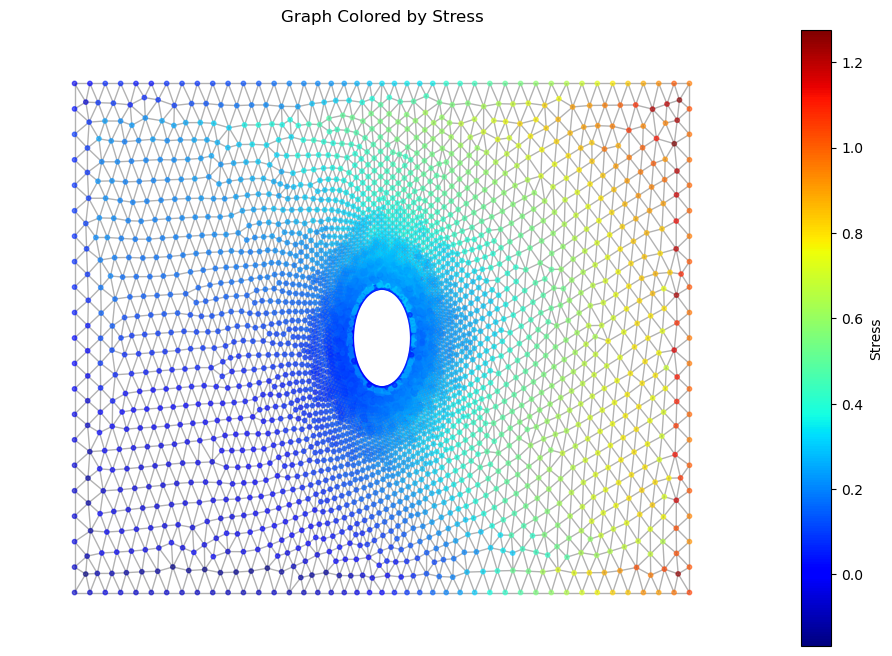

In [123]:
value = sxx

fig, ax = plt.subplots(figsize=(12, 8))

# Draw the graph on the given axis
nx.draw(G, pos, node_size=10, edge_color="gray", alpha=0.6,
        node_color=value, cmap="jet", vmin=value.min(), vmax=value.max(),
        ax=ax)

# Create a mappable and assign the stress values to it for the colorbar
mappable = plt.cm.ScalarMappable(cmap="jet")
mappable.set_array(value)

# Add the colorbar to the figure, using the axis
fig.colorbar(mappable, ax=ax, label="Stress")

ax.set_title("Graph Colored by Stress")
plt.show()